# Grad-CAM
- 本教學將透過 Grad-CAM 來說明影像神經網路模型的可解釋性
- Grad-CAM 論文連結：https://arxiv.org/abs/1610.02391
- 本教學程式碼改寫自 [`TorchCAM`](https://github.com/frgfm/torch-cam) 套件之範例程式碼
  - https://github.com/frgfm/notebooks/blob/main/torch-cam/quicktour.ipynb
  - [TorchCAM 官方文件](https://frgfm.github.io/torch-cam/index.html)

In [4]:
!pip install torchcam
!pip install torchvision==0.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/

In [1]:
!pip list | grep torchvision

torchvision                           0.22.0


In [2]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

import matplotlib.pyplot as plt

In [3]:
# Get your input
img = read_image(
    "shiba_inu.JPG",
    apply_exif_orientation=True, # 避免來自手機的影像載入後旋轉 90 度
)

In [4]:
# Preprocess it for your chosen model
input_tensor = normalize(
    tensor = resize(img, (224, 224)) / 255.,
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225],
)

In [5]:
model = resnet18(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


In [6]:
with GradCAM(model) as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [7]:
# Resize the CAM and overlay it
result = overlay_mask(
    img = to_pil_image(img),
    mask = to_pil_image(activation_map[0].squeeze(0), mode='F'), # mask to be overlayed in grayscale
    colormap = 'jet', # 'jet' colormap 是最常用的熱力圖顏色映射
    alpha = 0.5, # transparency of the background image
)

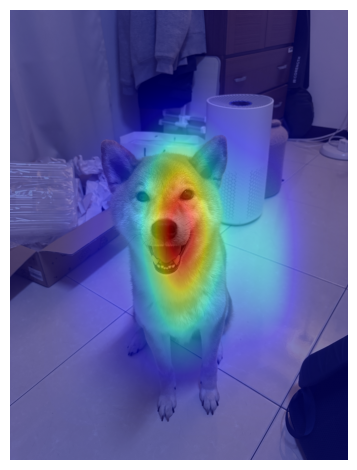

<Figure size 640x480 with 0 Axes>

In [8]:
# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the result
plt.savefig("grad_cam.png", dpi=200, transparent=True, bbox_inches="tight", pad_inches=0)